In [218]:
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

import itertools
from pathlib import Path
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
# Reading all data into all_event_data

root_path = Path('data/')
company_basket_file = root_path / 'company_basket.csv'

# Load basket data
basket_df = pd.read_csv(company_basket_file, sep=";")

all_event_data = pd.DataFrame()
all_txt_files = list(root_path.rglob('Sweden*.txt'))
all_csv_file = list(root_path.rglob('data*.csv'))
for event_file in tqdm.tqdm(all_txt_files, desc="Iterating all txt files"):
    current_df = pd.read_csv(event_file, sep=";")
    all_event_data = pd.concat([all_event_data, current_df], ignore_index=True)

for event_file in tqdm.tqdm(all_csv_file, desc="Iterating all csv files"):
    current_df = pd.read_csv(event_file, sep=",")
    all_event_data = pd.concat([all_event_data, current_df], ignore_index=True)

Iterating all csv files: 100%|█████████████████████████████████████████████| 11/11 [00:11<00:00,  1.04s/it]


In [189]:
# Generate one hot encoding for each company based on industry_name and economic_sector_name

# Drop duplicates when ['country_name', 'industry_name', 'economic_sector_name', 'company_name'] are the same
company_dedup_columns = ['country_name', 'industry_name', 'economic_sector_name', 'company_name']
company_overview_data = all_event_data.drop_duplicates(subset=company_dedup_columns)
company_overview_data = company_overview_data[company_dedup_columns]

# --------- One-Hot Encoding Industry and Sector ---------
industry_encoded = pd.get_dummies(company_overview_data[['country_name','company_name', 'industry_name']], columns=['industry_name'], dtype=int)
sector_encoded = pd.get_dummies(company_overview_data[['country_name','company_name', 'economic_sector_name']], columns=['economic_sector_name'], dtype=int)

In [151]:
# Classify companies based on their latest Mcap

# Only keep rows where ['finparametername'] == 'Mcap'
mcap_df = all_event_data[all_event_data['finparametername'] == 'Mcap'].copy()

# Sort endtime and only keep the latest (drop_duplicates only keep the first one)
latest_mcap_df = (mcap_df
    .sort_values('endtime', ascending=False)
    .drop_duplicates(subset=['country_name', 'industry_name', 'economic_sector_name', 'company_name'])
)

# Define Market Cap bins
mcap_bins = [0, 2e9, 10e9, float("inf")]  # Small, Mid, Large Cap
mcap_labels = ["Small", "Medium", "Large"]

latest_mcap_df["Size Category"] = pd.cut(latest_mcap_df["finval"], bins=mcap_bins, labels=mcap_labels)
latest_mcap_df.head()

,country_name,industry_name,economic_sector_name,company_name,finparametername,endtime,finval,Size Category
11217504,United States of America,Specialty Chemicals,Basic Materials,CSW Industrials Inc,Mcap,2024-08-07 00:00:00,4.755978e+09,Medium
11218628,United States of America,Airlines,Industrials,Hawaiian Holdings Inc,Mcap,2024-08-07 00:00:00,6.423208e+08,Small
11289148,New Zealand,Electric Utilities,Utilities,Genesis Energy Ltd,Mcap,2024-08-07 00:00:00,2.630302e+09,Medium
11239094,United States of America,Leisure & Recreation,Consumer Cyclicals,Travelzoo,Mcap,2024-08-07 00:00:00,2.637225e+08,Small
11289245,Canada,Electric Utilities,Utilities,Innergex Renewable Energy Inc,Mcap,2024-08-07 00:00:00,2.098220e+09,Medium


In [185]:
mcap_encoded = pd.get_dummies(latest_mcap_df[['country_name','company_name','industry_name','economic_sector_name','Size Category']], columns=['Size Category'], dtype=int)
mcap_encoded.head()

,country_name,company_name,industry_name,economic_sector_name,Size Category_Small,Size Category_Medium,Size Category_Large
11217504,United States of America,CSW Industrials Inc,Specialty Chemicals,Basic Materials,0,1,0
11218628,United States of America,Hawaiian Holdings Inc,Airlines,Industrials,1,0,0
11289148,New Zealand,Genesis Energy Ltd,Electric Utilities,Utilities,0,1,0
11239094,United States of America,Travelzoo,Leisure & Recreation,Consumer Cyclicals,1,0,0
11289245,Canada,Innergex Renewable Energy Inc,Electric Utilities,Utilities,0,1,0


In [124]:
# -----Volatility Classification 1 (high, medium, low):  by Industry-Relative Classification-------
closing_price_df = all_event_data[all_event_data['finparametername'] == 'closingPrice'].copy()

closing_price_df = closing_price_df.sort_values([
    'country_name', 'industry_name', 'economic_sector_name', 'company_name', 'endtime'
])

# Create a list to store results
volatility_results = []

# Group by all company identifier fields
company_groups = closing_price_df.groupby([
    'country_name', 'industry_name', 'economic_sector_name', 'company_name'
])

for company_key, company_data in tqdm.tqdm(company_groups):
    country, industry, sector, company = company_key
    
    # Convert to time series and calculate returns
    prices = company_data.set_index('endtime')['finval']
    returns = prices.pct_change().dropna()
    
    # Calculate annualized volatility (assuming daily data)
    daily_vol = returns.std()
    annualized_vol = daily_vol * np.sqrt(252)
    
    # Store result
    volatility_results.append({
        'country_name': country,
        'industry_name': industry,
        'economic_sector_name': sector,
        'company_name': company,
        'price_volatility': annualized_vol
    })

# Create result dataframe
volatility_df = pd.DataFrame(volatility_results)

industry_groups = volatility_df.groupby('industry_name')

volatility_df['volatility_category'] = 'Medium'

for industry, group in industry_groups:
    low_threshold = group['price_volatility'].quantile(0.33)
    high_threshold = group['price_volatility'].quantile(0.67)
    
    # Apply industry-specific thresholds
    industry_mask = volatility_df['industry_name'] == industry
    volatility_df.loc[industry_mask & (volatility_df['price_volatility'] <= low_threshold), 'volatility_category'] = 'Low'
    volatility_df.loc[industry_mask & (volatility_df['price_volatility'] >= high_threshold), 'volatility_category'] = 'High'

100%|████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 1571.86it/s]


In [112]:
volatility_df.head()
volatility_df["volatility_category"].value_counts()

volatility_category
High      903
Low       894
Medium    876
Name: count, dtype: int64

In [115]:
# -----Volatility Classification 2 (high, medium, low):  by Fixed Thresholds Based on Financial Industry Standards-------

closing_price_df = all_event_data[all_event_data['finparametername'] == 'closingPrice'].copy()

closing_price_df = closing_price_df.sort_values([
    'country_name', 'industry_name', 'economic_sector_name', 'company_name', 'endtime'
])

# Create a list to store results
volatility_results = []

# Group by all company identifier fields
company_groups = closing_price_df.groupby([
    'country_name', 'industry_name', 'economic_sector_name', 'company_name'
])

for company_key, company_data in tqdm.tqdm(company_groups):
    country, industry, sector, company = company_key
    
    # Convert to time series and calculate returns
    prices = company_data.set_index('endtime')['finval']
    returns = prices.pct_change().dropna()
    
    # Calculate annualized volatility (assuming daily data)
    daily_vol = returns.std()
    annualized_vol = daily_vol * np.sqrt(252)
    
    # Store result
    volatility_results.append({
        'country_name': country,
        'industry_name': industry,
        'economic_sector_name': sector,
        'company_name': company,
        'price_volatility': annualized_vol
    })

# Create result dataframe
volatility_df = pd.DataFrame(volatility_results)

def classify_stock_volatility(volatility_df):
    # First cap extreme values (e.g., above 99th percentile)
    cap_value = volatility_df['price_volatility'].quantile(0.99)
    volatility_df['price_volatility_capped'] = volatility_df['price_volatility'].clip(upper=cap_value)
    
    # Apply standard classifications to capped values
    volatility_df['volatility_category'] = 'Medium'
    volatility_df.loc[volatility_df['price_volatility_capped'] < 0.15, 'volatility_category'] = 'Low'
    volatility_df.loc[volatility_df['price_volatility_capped'] > 0.30, 'volatility_category'] = 'High'
    
    return volatility_df

volatility_df_2 = classify_stock_volatility(volatility_df)



100%|████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 1442.94it/s]


In [117]:
volatility_df_2.head()

,country_name,industry_name,economic_sector_name,company_name,price_volatility,price_volatility_capped,volatility_category
0,Australia,Advanced Medical Equipment & Technology,Healthcare,4DMedical Ltd,0.896449,0.896449,High
1,Australia,Advanced Medical Equipment & Technology,Healthcare,Genetic Signatures Ltd,0.501416,0.501416,High
2,Australia,Advanced Medical Equipment & Technology,Healthcare,Optiscan Imaging Ltd,0.702512,0.702512,High
3,Australia,Advanced Medical Equipment & Technology,Healthcare,Pro Medicus Ltd,0.301271,0.301271,High
4,Australia,Advanced Medical Equipment & Technology,Healthcare,Respiri Ltd,0.787691,0.787691,High


In [175]:
volatility_encoded = pd.get_dummies(volatility_df_2[['country_name','company_name','industry_name','economic_sector_name','volatility_category']], columns=['volatility_category'], dtype=int)
volatility_encoded.head()

,country_name,company_name,industry_name,economic_sector_name,volatility_category_High,volatility_category_Low,volatility_category_Medium
0,Australia,4DMedical Ltd,Advanced Medical Equipment & Technology,Healthcare,1,0,0
1,Australia,Genetic Signatures Ltd,Advanced Medical Equipment & Technology,Healthcare,1,0,0
2,Australia,Optiscan Imaging Ltd,Advanced Medical Equipment & Technology,Healthcare,1,0,0
3,Australia,Pro Medicus Ltd,Advanced Medical Equipment & Technology,Healthcare,1,0,0
4,Australia,Respiri Ltd,Advanced Medical Equipment & Technology,Healthcare,1,0,0


In [207]:
#------Merging all features to create the stock_features----------

# Define the unique company identifier columns
company_id_columns = ['country_name', 'industry_name', 'economic_sector_name', 'company_name']

# Step 1: Get base company data
# Start with clean company information
base_company_data = company_overview_data[company_id_columns].copy()

# Step 2: Add market cap category (before encoding)
# Get the market cap categories
mcap_categories = latest_mcap_df[company_id_columns + ['Size Category']]
base_company_data = pd.merge(
    base_company_data,
    mcap_categories,
    on=company_id_columns,
    how='left'
)
# Step 3: Add volatility category (before encoding)
# Get the volatility categories
volatility_categories = volatility_df_2[company_id_columns + ['volatility_category']]
base_company_data = pd.merge(
    base_company_data,
    volatility_categories,
    on=company_id_columns,
    how='left'
)

# Step 4: Now one-hot encode all categorical features at once
# Apply one-hot encoding to all categorical columns except the ID columns
categorical_columns = ['industry_name', 'economic_sector_name', 'Size Category', 'volatility_category']
stock_features = pd.get_dummies(
    base_company_data, 
    columns=categorical_columns,
    dtype=int
)

# Fill any missing values with 0
stock_features = stock_features.fillna(0)

# Check the final result
print(f"Final stock_features shape: {stock_features.shape}")

stock_features.head()


Final stock_features shape: (2673, 149)


,country_name,company_name,industry_name_Advanced Medical Equipment & Technology,industry_name_Advertising & Marketing,industry_name_Aerospace & Defense,industry_name_Agricultural Chemicals,industry_name_Airlines,industry_name_Airport Operators & Services,industry_name_Aluminum,industry_name_Apparel & Accessories,...,economic_sector_name_Industrials,economic_sector_name_Real Estate,economic_sector_name_Technology,economic_sector_name_Utilities,Size Category_Small,Size Category_Medium,Size Category_Large,volatility_category_High,volatility_category_Low,volatility_category_Medium
0,Sweden,Concordia Maritime AB,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,Sweden,Igrene AB (publ),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,Sweden,Metacon AB (publ),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,Sweden,Midsummer AB,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,Sweden,Crown Energy AB,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [208]:
def create_basket_features(basket_df, stock_features):
    # Make copies to avoid modifying originals
    basket_df = basket_df.copy()
    stock_features = stock_features.copy()
    
    # Convert shares to decimals
    basket_df['company_share'] = basket_df['company_share'] / 100.0
    
    # Merge basket with stock features
    merged = pd.merge(basket_df, stock_features, on='company_name')
    
    # Get only numeric feature columns
    feature_cols = merged.select_dtypes(include=['number']).columns.drop('company_share')
    
    # Calculate weighted features
    for col in feature_cols:
        merged[col] = merged[col] * merged['company_share']
    
    # Sum features for each basket
    basket_features = merged.groupby('basket_name')[feature_cols].sum()
    
    return basket_features.reset_index()

# Create basket features
basket_features = create_basket_features(basket_df, stock_features)

basket_features.head()

,basket_name,industry_name_Advanced Medical Equipment & Technology,industry_name_Advertising & Marketing,industry_name_Aerospace & Defense,industry_name_Agricultural Chemicals,industry_name_Airlines,industry_name_Airport Operators & Services,industry_name_Aluminum,industry_name_Apparel & Accessories,industry_name_Apparel & Accessories Retailers,...,economic_sector_name_Industrials,economic_sector_name_Real Estate,economic_sector_name_Technology,economic_sector_name_Utilities,Size Category_Small,Size Category_Medium,Size Category_Large,volatility_category_High,volatility_category_Low,volatility_category_Medium
0,Air related companies world,0.0,0.0,0.0,0.0,0.0001,8.223301e-08,0.00000,0.0,0.0,...,1.000000e-04,0.0,0.000000,0.0,0.000032,0.000068,0.0,0.000078,0.0,0.000022
1,Aluminium,0.0,0.0,0.0,0.0,0.0000,0.000000e+00,0.00001,0.0,0.0,...,0.000000e+00,0.0,0.000000,0.0,0.000010,0.000000,0.0,0.000010,0.0,0.000000
2,Aussi Fin,0.0,0.0,0.0,0.0,0.0000,0.000000e+00,0.00000,0.0,0.0,...,0.000000e+00,0.0,0.000000,0.0,0.000100,0.000000,0.0,0.000037,0.0,0.000063
3,Aussi Fin extra,0.0,0.0,0.0,0.0,0.0000,0.000000e+00,0.00000,0.0,0.0,...,2.633531e-07,0.0,0.000006,0.0,0.000100,0.000000,0.0,0.000094,0.0,0.000006
4,Aussi Fin extra ny,0.0,0.0,0.0,0.0,0.0000,0.000000e+00,0.00000,0.0,0.0,...,2.633531e-07,0.0,0.000006,0.0,0.000100,0.000000,0.0,0.000094,0.0,0.000006


In [209]:
# Compute cosine similarity matrix (n_basket, n_basket)
similarity_matrix = cosine_similarity(basket_features.iloc[:, 1:].values)

# Get the basket index mapping from unique baskets
basket_to_idx = {name: idx for idx, name in enumerate(basket_features['basket_name'])}

# Function to get similar baskets
def get_similar_baskets(basket_name, similarity_matrix, n=10): 
    if basket_name not in basket_features['basket_name'].values:
        print("\nAvailable baskets:")
        print(sorted(basket_features['basket_name'].unique()))
        raise ValueError(f"\nBasket '{basket_name}' not found in the data")

    # Get index for the target basket
    target_idx = basket_to_idx[basket_name]
    
    similarity_scores = list(enumerate(similarity_matrix[target_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    # Get basket names corresponding to top similar indices
    similar_baskets = [list(basket_to_idx.keys())[i[0]] for i in similarity_scores]

    return similar_baskets

In [216]:
similar = get_similar_baskets("BIG INDEX Global", similarity_matrix, n=10)
print("\nSimilar baskets to 'BIG INDEX Global':")
print(similar)


Similar baskets to 'BIG INDEX Global':
['MooseBit explosion', 'Solar energy', 'renewable Fuelss', 'EBITDA Sweden', 'Oceania valuecreators', 'Global index great valuers', 'Well traded with profit margin', 'Swedish weaked valued', 'Nordic Green Energy', 'Energy well performance']


Found rows: 8
Number of unique baskets: 197
Number of baskets in features: 197
Number of baskets in mapping: 197
Missing companies:
                      basket_name      company_name  company_share
1160  German and French companies  AlzChem Group AG       4.978419
1274  German companies all sector  AlzChem Group AG      16.482957
2025         MooseBit - best case  AlzChem Group AG       1.542138
2798           Software in Sweden       AppSpotr AB       0.147059
2865                 Solar energy      TubeSolar AG       2.000000

Number of lost companies per basket:
basket_name
German and French companies    1
German companies all sector    1
MooseBit - best case           1
Software in Sweden             1
Solar energy                   1
Name: company_name, dtype: int64


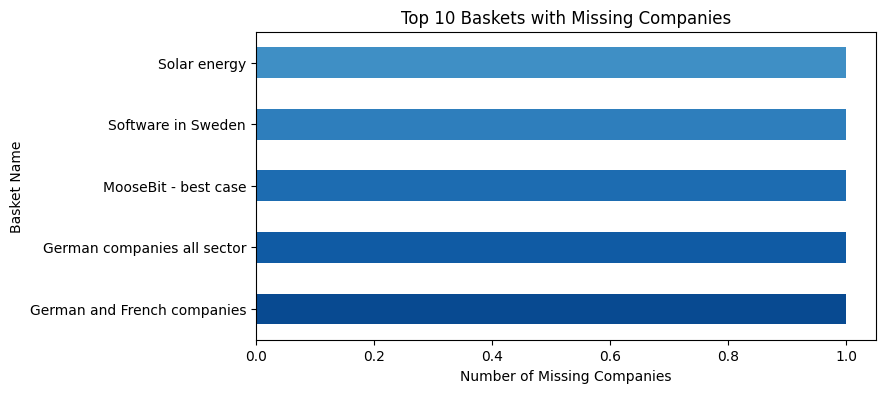

In [219]:
# Debug information
merged = pd.merge(basket_df, stock_features, on='company_name')
merged
wtf_rows = merged[merged['basket_name'] == "WTF II"]
print("Found rows:", len(wtf_rows))

num_baskets = basket_df['basket_name'].nunique()
print(f"Number of unique baskets: {num_baskets}")
print("Number of baskets in features:", len(basket_features))
print("Number of baskets in mapping:", len(basket_to_idx))

# Check companies in basket_df that aren't in stock_features
missing_companies = basket_df[~basket_df['company_name'].isin(stock_features['company_name'])]
print("Missing companies:")
print(missing_companies)

# Check how many companies are lost per basket
lost_companies = missing_companies.groupby('basket_name')['company_name'].count()
lost_companies = lost_companies.sort_values(ascending=False)
n_lost_companies = 10
plt.figure(figsize=(8, 4))
colors = plt.cm.Blues(np.linspace(0.9, 0.3, n_lost_companies))
lost_companies.head(n_lost_companies).plot(kind='barh', color=colors)
plt.title('Top 10 Baskets with Missing Companies')
plt.xlabel('Number of Missing Companies')
plt.ylabel('Basket Name')
print("\nNumber of lost companies per basket:")
print(lost_companies)